# Тестирование возможностей библиотеки Prophet

In [1]:
# Литература - Сергей Мастицкий https://ranalytics.github.io/tsa-with-r/ch-intro-to-prophet.html

In [2]:
# Вебинар на Youtube - БЕСЛАН КУРАШОВ (Cооснователь и преподаватель в karpov.courses) "Всё, что вы хотели знать о Facebook Prophet"

In [3]:
# Документация - https://facebook.github.io/prophet/docs/quick_start.html

In [4]:
# Тематическая публикация на Хабр - "Предсказываем будущее с помощью библиотеки Facebook Prophet"

In [5]:
%%capture
!pip install fbprophet

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime
import copy
import holidays
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.plot import plot_cross_validation_metric
from scipy.special import inv_boxcox
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [7]:
pd.set_option("display.max.columns", None)

In [8]:
parser = lambda _: datetime.strptime(_, '%d.%m.%Y')
df = pd.read_csv("/content/drive/MyDrive/dataset/data.csv", 
                 sep=';', 
                 parse_dates=['dt'], 
                 date_parser=parser)

In [9]:
columns_name = ['ds','y']
df.columns = columns_name

In [10]:
print(df.head(10))

          ds  y
0 2016-01-01  2
1 2016-01-02  3
2 2016-01-03  4
3 2016-01-04  3
4 2016-01-05  4
5 2016-01-06  2
6 2016-01-07  3
7 2016-01-08  3
8 2016-01-09  5
9 2016-01-10  4


In [11]:
df.shape

(1827, 2)

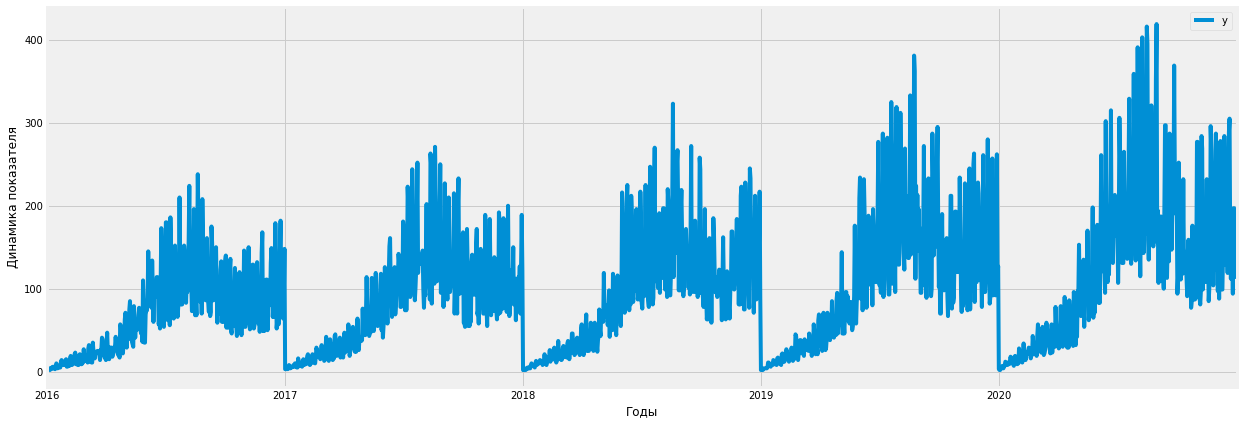

In [12]:
ax = df.set_index('ds').plot(figsize=(19, 7))
ax.set_ylabel('Динамика показателя')
ax.set_xlabel('Годы')
plt.show()

In [13]:
# Размер тестовой выборки
predictions = 180

In [14]:
# Формируем тренировочный датасет
train_df = df[:-predictions]

In [15]:
train_df.tail()

,ds,y
1642,2020-06-30,175
1643,2020-07-01,175
1644,2020-07-02,107
1645,2020-07-03,165
1646,2020-07-04,306


In [16]:
# Проверка на корректность разбития дасетов
(df.shape[0] - train_df.shape[0]) == predictions

True

In [17]:
# Добавление праздничных дней
holidays_dict = holidays.RU(years=(2016,2017,2018,2019,2020))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index').reset_index()
df_holidays = df_holidays.rename({'index':'ds',0:'holiday'},axis='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.head(10)

,ds,holiday
0,2016-01-01,Новый год
1,2016-01-02,Новый год
2,2016-01-03,Новый год
3,2016-01-04,Новый год
4,2016-01-05,Новый год
5,2016-01-06,Новый год
6,2016-01-07,Православное Рождество
7,2016-01-08,Новый год
8,2016-02-23,День защитника отечества
9,2016-03-08,День женщин


In [53]:
# Вызываем Prophet
m = Prophet( growth='linear', 
            holidays=df_holidays, 
            daily_seasonality=True, 
            yearly_seasonality=True, 
            weekly_seasonality=True, 
            seasonality_mode='multiplicative')
m.fit(train_df)

In [54]:
# Предсказание для 180 дней
future = m.make_future_dataframe(periods=predictions,freq='D')
forecast = m.predict(future)

In [55]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2016-01-01,4.514593,-28.460486,42.568914
1,2016-01-02,34.806680,0.251250,67.032863
2,2016-01-03,33.758968,-0.639860,69.301001
3,2016-01-04,-5.528589,-41.468174,29.918475
4,2016-01-05,-7.475138,-43.491992,29.038669


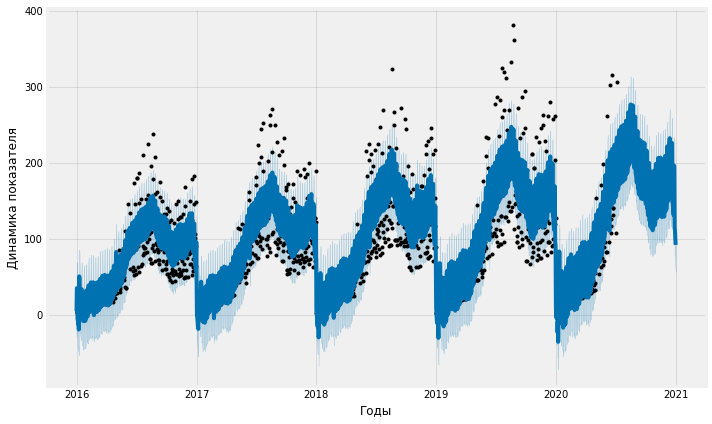

In [56]:
# Отображение прогноза
fig1 = m.plot(forecast, xlabel='Годы', ylabel='Динамика показателя')

In [57]:
fig2 = plot_plotly(m, forecast)
fig2.show(renderer="colab")

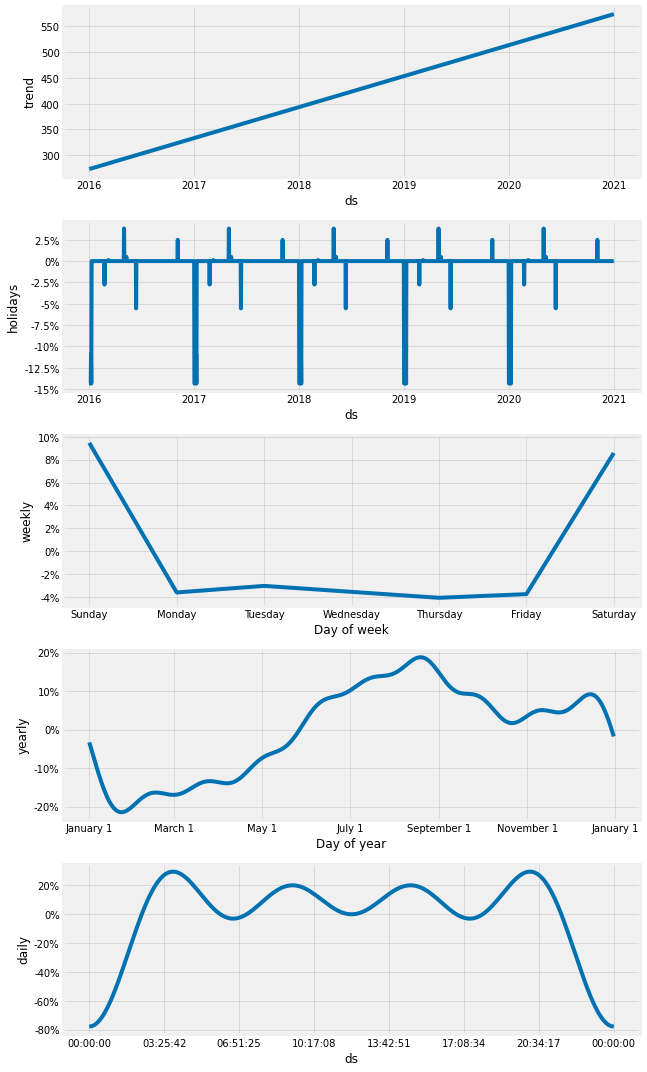

In [58]:
# Тренд, годовая и недельная сезонность
fig3 = m.plot_components(forecast)

In [59]:
fig4 = plot_components_plotly(m, forecast)
fig4.show(renderer="colab")

In [60]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
init_notebook_mode(connected = True)

fig5 = go.Figure([
       go.Scatter(x=df['ds'],y=df['y'], name='fact'),
       go.Scatter(x=forecast['ds'],y=forecast['yhat'],name='pred'),
       go.Scatter(x=forecast['ds'],y=forecast['yhat_upper'],fill='tonexty',mode='none', name='upper'),
       go.Scatter(x=forecast['ds'],y=forecast['yhat_lower'],fill='tonexty',mode='none', name='lower'),
       go.Scatter(x=forecast['ds'],y=forecast['trend'],name='trend')
])
fig5.show(renderer="colab")

In [61]:
# Объединение forecast с исходными наблюдениями
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [62]:
# Для оценки качества модели возьмем только последние 180 дней, для которых модель строила прогноз
cmp_df_180 = copy.deepcopy(cmp_df.tail(180))

In [63]:
# Расчет метрик MAPE и MAE
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
mae = round(np.mean(abs(cmp_df['e'])),2)
mape = round(np.mean(abs(cmp_df['p'])),2)
print(f"Mean absolute percentage error (MAPE) of our forecasts is {mape}")
print(f"Mean absolute error (MAE) of our forecasts is {mae}")

Mean absolute percentage error (MAPE) of our forecasts is 54.65
Mean absolute error (MAE) of our forecasts is 22.78
